# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [225]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 
from matplotlib import colorbar as mpl_colorbar
import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

from multiprocessing import Pool, cpu_count
from contextlib import closing

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [3]:
opsimdf

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1068,227,505,1.720374,-0.936476,y,2922,59580.033829,0,...,0.000000,105.043185,0.920473,0.0,0.0,1.659226,0.000000,21.013506,1.694604,-0.962927
1,2,1068,227,567,1.648235,-0.903353,y,2961,59580.034278,0,...,0.000000,101.373243,0.920473,0.0,0.0,0.054827,4.769109,21.058304,1.623562,-0.929804
2,3,1068,227,561,1.563788,-0.915583,y,3000,59580.034726,0,...,0.000000,98.042992,0.920473,0.0,0.0,0.053275,4.780469,21.099047,1.538724,-0.942034
3,4,1068,227,539,1.477422,-0.924531,y,3039,59580.035175,0,...,0.000000,95.139389,0.920473,0.0,0.0,0.053066,4.762092,21.134714,1.452062,-0.950982
4,5,1068,227,531,1.389669,-0.930365,y,3077,59580.035623,0,...,0.000000,92.619319,0.920473,0.0,0.0,0.052952,4.739055,21.165823,1.364111,-0.956816
5,6,1068,227,517,1.301075,-0.933239,y,3116,59580.036071,0,...,0.000000,90.448151,0.920473,0.0,0.0,0.052904,4.709074,21.192773,1.275418,-0.959690
6,7,1068,227,519,1.212198,-0.933238,y,3155,59580.036519,0,...,0.000000,88.596990,0.920473,0.0,0.0,0.052892,4.669665,21.215880,1.186541,-0.959689
7,8,1068,227,523,1.123604,-0.930366,y,3193,59580.036967,0,...,0.000000,87.040118,0.920473,0.0,0.0,0.052904,4.742319,21.235417,1.098046,-0.956817
8,9,1068,227,541,1.035849,-0.924530,y,3233,59580.037422,0,...,0.000000,85.753276,0.920473,0.0,0.0,0.052953,5.250509,21.251646,1.010489,-0.950981
9,10,1068,227,698,0.988892,-0.827713,y,3272,59580.037880,0,...,0.000000,83.013952,0.920473,0.0,0.0,0.101357,5.588682,21.286460,0.966319,-0.854164


In [4]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [5]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

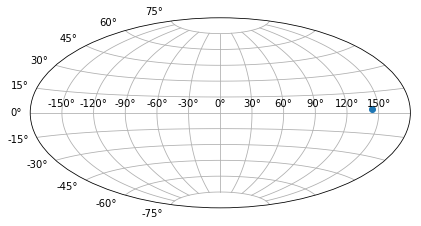

In [6]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [7]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [8]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [9]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [10]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

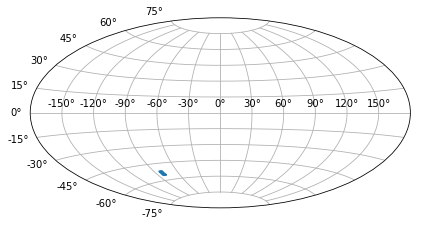

In [11]:
reload(utils)
utils.plot_field(working_df)

In [12]:
df = opsimdf

In [13]:
## Work out how often each field is visited
min_visits = df["fieldID"].value_counts().min()
max_visits = df["fieldID"].value_counts().max()

print(min_visits, ",",max_visits)

df['count'] = df.groupby('fieldID').cumcount()

180 , 23271


In [160]:
ddf = [1427,744,2412,290,2786  ]

In [14]:
cmap = plt.get_cmap("viridis")
# df["cmap_visit_value"] = (df["count"] - min_visits )/(max_visits - min_visits)
df["cmap_visit_value"] = np.log((df["count"] + 1)/(max_visits+1))

In [15]:
df["cmap_visit_value"] = df["cmap_visit_value"] + np.abs(df["cmap_visit_value"].min())
df["cmap_visit_value"] = df["cmap_visit_value"]/df["cmap_visit_value"].max()

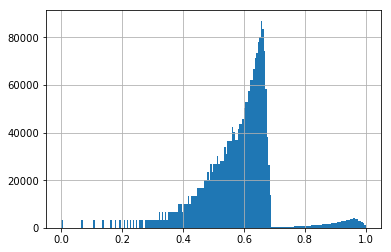

In [16]:
df["cmap_visit_value"].hist(bins = 200)

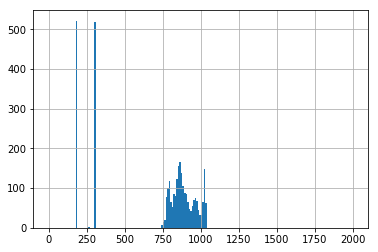

In [158]:
df["fieldID"].value_counts().hist(bins = 200, range = [0, 2000])

In [18]:
df = utils.get_field_corners(df)

In [121]:
night_group = df.groupby("night")

In [20]:
#TEST
# i = 0
# group = night_group.groups[0]
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_night_"
# fig = plt.figure()
# fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                     right = 0.97, hspace=0, wspace = .1)

# ax_aitoff = fig.add_subplot(111, projection="aitoff")
# ax_aitoff.grid(True)
# ax_aitoff.scatter(df["fieldRA"][group] - np.pi, df["fieldDec"][group], color = cmap(df["cmap_visit_value"][group]))
# fig.savefig(outpath + str(i)+".pdf", format = 'pdf', dpi=500)
# plt.close()

In [ ]:
# for group in night_group.groups:
#     print(night_group.groups[0])

In [122]:
df_to_plot

,fieldID,fieldRA,fieldDec,cmap_visit_value
0,505,1.720374,-0.936476,0.000000
1,567,1.648235,-0.903353,0.000000
2,561,1.563788,-0.915583,0.000000
3,539,1.477422,-0.924531,0.000000
4,531,1.389669,-0.930365,0.000000
5,517,1.301075,-0.933239,0.000000
6,519,1.212198,-0.933238,0.000000
7,523,1.123604,-0.930366,0.000000
8,541,1.035849,-0.924530,0.000000
9,698,0.988892,-0.827713,0.000000


In [129]:
df_to_plot.loc[night_group.groups[0]]

,fieldID,fieldRA,fieldDec,cmap_visit_value
0,505,1.720374,-0.936476,0.000000
1,567,1.648235,-0.903353,0.000000
2,561,1.563788,-0.915583,0.000000
3,539,1.477422,-0.924531,0.000000
4,531,1.389669,-0.930365,0.000000
5,517,1.301075,-0.933239,0.000000
6,519,1.212198,-0.933238,0.000000
7,523,1.123604,-0.930366,0.000000
8,541,1.035849,-0.924530,0.000000
9,698,0.988892,-0.827713,0.000000


In [141]:
x = len(night_group.groups)

In [146]:
str('%05d' % x)

'03020'

In [189]:
df_to_plot

,fieldID,fieldRA,fieldDec,cmap_visit_value
0,505,1.720374,-0.936476,0.000000
1,567,1.648235,-0.903353,0.000000
2,561,1.563788,-0.915583,0.000000
3,539,1.477422,-0.924531,0.000000
4,531,1.389669,-0.930365,0.000000
5,517,1.301075,-0.933239,0.000000
6,519,1.212198,-0.933238,0.000000
7,523,1.123604,-0.930366,0.000000
8,541,1.035849,-0.924530,0.000000
9,698,0.988892,-0.827713,0.000000


/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [226]:
# def plot_obs(df):
#     outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"

#     df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]
#     df_to_plot["zorder"] = df_to_plot["fieldID"]*0
#     df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99

#     norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


#     for i, group in enumerate(np.arange(10)):
#     # for i, group in enumerate(night_group.groups):

#         if i == 0:
#             fig = plt.figure()
#             fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                                 right = 0.97, hspace=0, wspace = .1)

#     #         ax_aitoff = fig.add_subplot(111, projection="aitoff")      
#             ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#             ax_aitoff.grid(True)
#             ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
#     #         ax_active = fig.add_subplot(111, projection="aitoff")


#             working_df_to_plot = df_to_plot.loc[night_group.groups[group]]
#         else:
#             working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
#             working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

#     #     ax_aitoff.scatter(working_df_to_plot["fieldRA"][night_group.groups[group]] - np.pi, 
#     #               working_df_to_plot["fieldDec"][night_group.groups[group]], 
#     #               color = cmap(working_df_to_plot["cmap_visit_value"][night_group.groups[group]]))

#         ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#                           working_df_to_plot["fieldDec"], 
#                           color = cmap(working_df_to_plot["cmap_visit_value"]))

#         ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
#                           working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
#                           color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
#                           )

#     #     fig_cont = fig

#     #     ax_active.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#     #                       working_df_to_plot["fieldDec"], 
#     #                       color = cmap(working_df_to_plot["cmap_visit_value"]),
#     #                       linewidths = 0.5 , edgecolors = colours.hex["black"])

#         cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
#                                     norm=norm)
#         fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)

#     #     ax_active.clear()
#     #     print(len(working_df_to_plot))
#     # plt.close()

/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

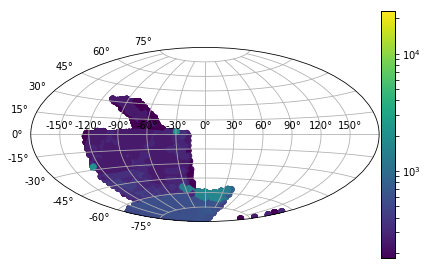

In [230]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]

# outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"
outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_night_"

df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99
norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


for i, group in enumerate(np.arange(10)):
# for i, group in enumerate(night_group.groups):

    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)

#         ax_aitoff = fig.add_subplot(111, projection="aitoff")      
        ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
        ax_aitoff.grid(True)
        ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
#         ax_active = fig.add_subplot(111, projection="aitoff")


        working_df_to_plot = df_to_plot.loc[night_group.groups[group]]
    else:
        working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
        working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

#     ax_aitoff.scatter(working_df_to_plot["fieldRA"][night_group.groups[group]] - np.pi, 
#               working_df_to_plot["fieldDec"][night_group.groups[group]], 
#               color = cmap(working_df_to_plot["cmap_visit_value"][night_group.groups[group]]))

    ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
                      working_df_to_plot["fieldDec"], 
                      color = cmap(working_df_to_plot["cmap_visit_value"]))

    ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
                      working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
                      color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
                      )

#     fig_cont = fig

#     ax_active.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#                       working_df_to_plot["fieldDec"], 
#                       color = cmap(working_df_to_plot["cmap_visit_value"]),
#                       linewidths = 0.5 , edgecolors = colours.hex["black"])

    cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm)
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)

#     ax_active.clear()
#     print(len(working_df_to_plot))
# plt.close()

In [209]:
working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"]

228    0.000000
229    0.068936
230    0.109261
231    0.137872
232    0.160064
233    0.178197
234    0.193527
235    0.206807
236    0.218521
237    0.229000
238    0.238479
239    0.247132
240    0.255093
241    0.262463
242    0.269325
243    0.275743
244    0.281773
245    0.287457
246    0.292834
247    0.297936
248    0.302788
249    0.307415
250    0.311835
251    0.316068
252    0.320128
253    0.324029
254    0.327782
255    0.331399
256    0.334889
257    0.338261
         ...   
294    0.418171
295    0.419644
296    0.421096
297    0.422527
298    0.423938
299    0.425329
300    0.426701
301    0.428054
302    0.429389
303    0.430706
304    0.432006
305    0.433289
306    0.434556
307    0.435807
308    0.437043
309    0.438263
310    0.439469
311    0.440660
312    0.441837
313    0.443000
314    0.444150
315    0.445286
316    0.446410
317    0.447521
318    0.448620
319    0.449707
320    0.450782
321    0.451846
322    0.452898
323    0.453940
Name: cmap_visit_value, 

In [199]:
df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]]

,fieldRA
228,0.925184
229,0.925184
230,0.925184
231,0.925184
232,0.925184
233,0.925184
234,0.925184
235,0.925184
236,0.925184
237,0.925184


In [105]:
# working_df_to_plot["fieldID"] in df_to_plot["fieldID"]
# df1 = working_df_to_plot.head(10)
# df2 = working_df_to_plot.tail(10)
df1 = df_to_plot.loc[df_to_plot["fieldID"] == 505].head(1)
df2 = df_to_plot.loc[df_to_plot["fieldID"] == 505].tail(1)

In [184]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 1

/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [186]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)]

228        1
229        1
230        1
231        1
232        1
233        1
234        1
235        1
236        1
237        1
238        1
239        1
240        1
241        1
242        1
243        1
244        1
245        1
246        1
247        1
248        1
249        1
250        1
251        1
252        1
253        1
254        1
255        1
256        1
257        1
          ..
2389707    1
2389708    1
2389709    1
2389710    1
2389711    1
2389712    1
2389713    1
2389714    1
2389715    1
2389716    1
2389717    1
2389718    1
2389719    1
2389720    1
2389721    1
2389722    1
2389723    1
2389724    1
2389725    1
2389726    1
2389727    1
2389728    1
2389729    1
2389730    1
2390228    1
2390257    1
2390265    1
2390292    1
2390818    1
2390842    1
Name: zorder, dtype: int64

In [107]:
df2

,fieldID,fieldRA,fieldDec,cmap_visit_value
2390480,505,1.720374,-0.936476,0.689649


In [111]:
df1

,fieldID,fieldRA,fieldDec,cmap_visit_value
0,505,1.720374,-0.936476,0.0


In [112]:
df3 = pd.concat([df1,df2])

In [113]:
df3

,fieldID,fieldRA,fieldDec,cmap_visit_value
0,505,1.720374,-0.936476,0.000000
2390480,505,1.720374,-0.936476,0.689649


In [115]:
df3.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

In [116]:
df3

,fieldID,fieldRA,fieldDec,cmap_visit_value
2390480,505,1.720374,-0.936476,0.689649


In [74]:
df.loc[df["fieldID"] == 505].head(10)

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,count,cmap_visit_value,RA_upper,RA_lower,Dec_upper,Dec_lower
0,1,1068,227,505,1.720374,-0.936476,y,2922,59580.033829,0,...,0.000000,21.013506,1.694604,-0.962927,0,0.000000,1.750917,1.689831,-0.967019,-0.905933
723,724,1068,227,505,1.720374,-0.936476,z,89448,59581.035286,1,...,4.630018,21.563110,1.701047,-0.962927,1,0.068936,1.750917,1.689831,-0.967019,-0.905933
1426,1427,1068,227,505,1.720374,-0.936476,z,116828,59581.352187,1,...,4.654791,21.648363,1.701047,-0.962927,2,0.109261,1.750917,1.689831,-0.967019,-0.905933
4377,4378,1068,227,505,1.720374,-0.936476,z,523087,59586.054253,6,...,4.651421,21.704848,1.733259,-0.962927,3,0.137872,1.750917,1.689831,-0.967019,-0.905933
13841,13841,1068,227,505,1.720374,-0.936476,y,1644453,59599.033030,19,...,4.617210,21.268988,1.688162,-0.956314,4,0.160064,1.750917,1.689831,-0.967019,-0.905933
14639,14639,1068,227,505,1.720374,-0.936476,y,1731724,59600.043113,20,...,4.891074,21.515723,1.694604,-0.956314,5,0.178197,1.750917,1.689831,-0.967019,-0.905933
15398,15398,1068,227,505,1.720374,-0.936476,y,1817471,59601.035552,21,...,4.816345,21.500725,1.701047,-0.956314,6,0.193527,1.750917,1.689831,-0.967019,-0.905933
15720,15720,1068,227,505,1.720374,-0.936476,i,1830780,59601.189588,21,...,4.753368,23.315915,1.701047,-0.956314,7,0.206807,1.750917,1.689831,-0.967019,-0.905933
15764,15764,1068,227,505,1.720374,-0.936476,i,1832559,59601.210174,21,...,4.828981,23.176625,1.701047,-0.956314,8,0.218521,1.750917,1.689831,-0.967019,-0.905933
16239,16239,1068,227,505,1.720374,-0.936476,g,1908141,59602.084973,22,...,6.222638,24.211174,1.707489,-0.956314,9,0.229000,1.750917,1.689831,-0.967019,-0.905933


In [ ]:
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_"


# for row in df.iterrows():
#     fig = plt.figure()
#     fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                         right = 0.97, hspace=0, wspace = .1)

#     ax_aitoff = fig.add_subplot(111, projection="aitoff")
#     ax_aitoff.grid(True)
#     ax_aitoff.scatter(row["fieldRA"] - np.pi, row["fieldDec"], color = cmap(row[cmap_visit_value]))
    
#     fig.savefig(outpath + row["obsHistID"]+".pdf", format = 'pdf', dpi=500)